In [1]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tabulate import tabulate
from collections import Counter

In [2]:
# Załadowanie modelu języka polskiego
nlp = spacy.load('pl_core_news_md')
opinions = pd.read_csv('../csv_data/preprocesed_files/anomaly_opinions.csv')
# Pobranie zawartości kolumny "content" jako listy zdań
sentences = opinions['content'].tolist()

opinions = pd.read_csv('../csv_data/preprocesed_files/anomaly_opinions.csv')

# Tworzenie listy krotek
opinions_list = [(row['content'], row['doubleQuality']) for _, row in opinions.iterrows()]
random.shuffle(opinions_list)

In [3]:
def unique_words_in_csv(sentences):
    lem_counter = Counter()
    for content in sentences:
        doc = nlp(content)

        for token in doc:
            if token.is_alpha and (not token.is_stop or token.lower_ == "niż" or token.lower_ == "od"):
                lem_counter[token.lemma_.lower()] += 1

    lemmas_count = list(zip(lem_counter.keys(), lem_counter.values()))
    sorted_lemmas_count = sorted(lemmas_count, key=lambda x: x[1], reverse=True)
    return sorted_lemmas_count


In [4]:
lemmas_count = unique_words_in_csv(sentences)
len(lemmas_count)

766

In [5]:
def print_lemmas_in_dataset(sorted_lemmas_count):
    # Przygotowanie danych do wykresu
    words = [lemma for lemma, count in sorted_lemmas_count if count > 5]
    counts = [count for lemma, count in sorted_lemmas_count if count > 5]

    # Generowanie wykresu słupkowego
    plt.figure(figsize=(10, 6))  # Zmiana rozmiaru wykresu
    plt.bar(range(len(words)), counts)
    plt.xticks(range(len(words)), words, rotation=45, ha='right')  # Obrót etykiet o 45 stopni
    plt.xlabel("Unikalne Słowa")
    plt.ylabel("Częstość występowania")
    plt.title("Częstość występowania unikalnych słów (częstość > 5)")
    plt.tight_layout()
    plt.show()

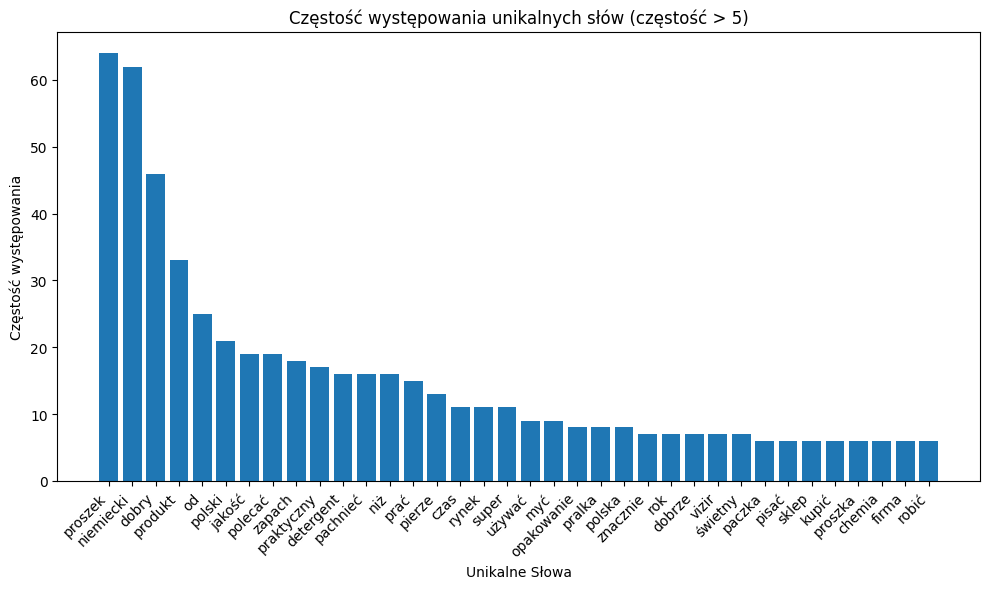

In [6]:
print_lemmas_in_dataset(lemmas_count)

In [7]:
# Inicjalizacja pustej listy
lemmas = []

# Iteracja po liście lemmas_count
for lemma, count in lemmas_count:
    if count > 5:
        lemmas.append(lemma)
len(lemmas)

36

In [8]:
def create_combinations(manually_selected_lemmas, lemmas):
    combinations = set()

    # Pary z manually_selected_lemmas i lemmas
    for lemma1 in manually_selected_lemmas:
        for lemma2 in lemmas:
            combination = tuple(sorted([lemma1, lemma2]))
            combinations.add(combination)

    # Pary z lemmas
    for lemma1 in lemmas:
        for lemma2 in lemmas:
            if lemma1 != lemma2:
                combination = tuple(sorted([lemma1, lemma2]))
                combinations.add(combination)

    # Usunięcie duplikatów i par z identycznymi słowami
    combinations = {(lemma1, lemma2) for lemma1, lemma2 in combinations if lemma1 != lemma2}

    return combinations


In [9]:
manually_selected_lemmas = ["niż", "lepszy", "lepiej", "rynek", "jakość", "znacznie", "od"]

combinations = create_combinations(manually_selected_lemmas, lemmas)

for combination in combinations:
    print(combination)

print("Liczba kombinacji:", len(combinations))

('sklep', 'używać')
('prać', 'vizir')
('niemiecki', 'rok')
('czas', 'myć')
('pisać', 'pralka')
('detergent', 'polecać')
('detergent', 'niż')
('czas', 'vizir')
('kupić', 'paczka')
('kupić', 'świetny')
('pralka', 'świetny')
('lepiej', 'robić')
('niż', 'opakowanie')
('lepiej', 'proszek')
('opakowanie', 'produkt')
('niż', 'polska')
('firma', 'opakowanie')
('od', 'używać')
('dobry', 'lepszy')
('dobry', 'pisać')
('proszka', 'używać')
('lepszy', 'prać')
('chemia', 'opakowanie')
('praktyczny', 'produkt')
('praktyczny', 'super')
('paczka', 'pralka')
('pachnieć', 'robić')
('lepiej', 'od')
('opakowanie', 'polska')
('dobrze', 'paczka')
('pachnieć', 'proszek')
('jakość', 'praktyczny')
('jakość', 'lepiej')
('polecać', 'prać')
('polski', 'używać')
('proszka', 'rynek')
('proszek', 'zapach')
('lepszy', 'sklep')
('proszek', 'znacznie')
('dobry', 'produkt')
('dobry', 'super')
('prać', 'świetny')
('jakość', 'prać')
('czas', 'paczka')
('czas', 'świetny')
('polecać', 'sklep')
('produkt', 'używać')
('dobry',

In [10]:
def rule_based_double_quality_search(opinions, combinations):
    total_sentences = len(opinions)
    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0

    for txt in opinions:
        # Przetworzenie zdania na tokeny
        doc = nlp(txt[0])

        # Tworzenie listy lematów zdania
        lemmas = [token.lemma_.lower() for token in doc]

        # Tworzenie kombinacji lematów zdania
        sentence_combinations = set()
        for lemma1, lemma2 in combinations:
            if lemma1 in lemmas and lemma2 in lemmas:
                sentence_combinations.add((lemma1, lemma2))

        # Sprawdzenie liczby kombinacji
        if len(sentence_combinations) > 10:
            if txt[1] == 1:
                true_positives += 1
            else:
                false_positives += 1
        else:
            if txt[1] == 0:
                true_negatives += 1
            else:
                false_negatives += 1
    
    # Tworzenie listy z danymi
    data = [
        ["Liczba zdań ze zbioru:", total_sentences],
        ["TP:", true_positives],
        ["FN:", false_negatives],
        ["FP:", false_positives],
        ["TN:", true_negatives]
    ]

    
    # Obliczenie metryk
    if (true_positives + false_positives) != 0:
        precision = true_positives / (true_positives + false_positives)
    else:
        precision = 0.0

    if (true_positives + false_negatives) != 0:
        recall = true_positives / (true_positives + false_negatives)
    else:
        recall = 0.0

    if (true_positives + true_negatives + false_positives + false_negatives) != 0:
        accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    else:
        accuracy = 0.0

    if (precision + recall) != 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0.0

    if (true_positives + true_negatives + false_positives + false_negatives) != 0:
        loss = (false_positives + false_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    else:
        loss = 0.0
        
    # Dodanie metryk do listy danych
    data.extend([
        ["Miary:"],
        ["Precision (precyzja):", precision],
        ["Recall (czułość):", recall],
        ["Accuracy (dokładność):", accuracy],
        ["Loss (strata):", loss],
        ["F1 Score (miara F1):", f1_score]
    ])

    # Wypisanie danych w postaci tabeli
    print(tabulate(data, headers=["Miary","Wartości"], tablefmt="fancy_grid"))

    confusion_matrix = [[true_positives, false_negatives], [false_positives, true_negatives]]

   # Tworzenie etykiet dla macierzy pomyłek
    labels = [["Pozytywna", "Negatywna"], ["Pozytywna", "Negatywna"]]

    # Wykreślenie Confusion Matrix z etykietami
    sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=labels[0], yticklabels=labels[1])
    plt.xlabel("Klasa predykowana")
    plt.ylabel("Klasa rzeczywista")
    plt.title("Tablica pomyłek")
    plt.show()

╒════════════════════════╤════════════╕
│ Miary                  │   Wartości │
╞════════════════════════╪════════════╡
│ Liczba zdań ze zbioru: │ 107        │
├────────────────────────┼────────────┤
│ TP:                    │  31        │
├────────────────────────┼────────────┤
│ FN:                    │  76        │
├────────────────────────┼────────────┤
│ FP:                    │   0        │
├────────────────────────┼────────────┤
│ TN:                    │   0        │
├────────────────────────┼────────────┤
│ Miary:                 │            │
├────────────────────────┼────────────┤
│ Precision (precyzja):  │   1        │
├────────────────────────┼────────────┤
│ Recall (czułość):      │   0.28972  │
├────────────────────────┼────────────┤
│ Accuracy (dokładność): │   0.28972  │
├────────────────────────┼────────────┤
│ Loss (strata):         │   0.71028  │
├────────────────────────┼────────────┤
│ F1 Score (miara F1):   │   0.449275 │
╘════════════════════════╧════════════╛


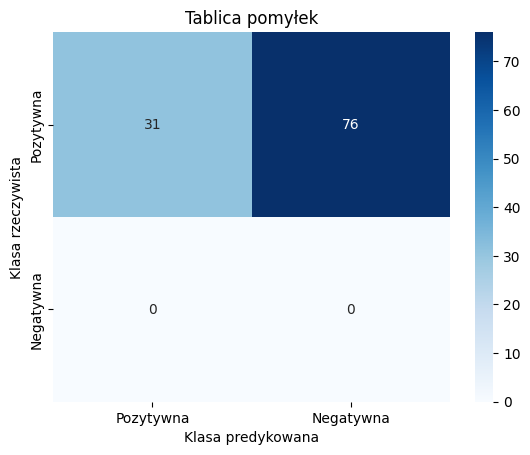

In [11]:
rule_based_double_quality_search(opinions_list, combinations)